In [1]:
import torch
import numpy as np
import pandas as pd
import glob
import os

import matplotlib.pyplot as plt

In [20]:
# Define the folder containing CSV files
def retrieveData(datasest, initialization, trial, variance, hidden_shape, act_func, lr, batchsize):

    path = f'./CollectedData/{datasest}/{initialization}/{trial}_{variance}_{len(hidden_shape)}__{hidden_shape[0]}_{act_func}_{lr}_{batchsize}'
    # Find all CSV files in the folder
    loss_data = torch.load(path+'_loss_data.pt')
    accuacy_data = torch.load(path+'_accuracy_data.pt')

    return torch.tensor(loss_data), torch.tensor(accuacy_data)

In [22]:
dataset = '010101010_data'
initialization = 'Default_Initialization'
trial = 1
variance = 1/16
hidden_shape = [2]
act_func = 1
lr = .01
batchsize = 10

loss_data, accuracy_data = retrieveData(dataset, initialization, trial, variance, hidden_shape, act_func, lr, batchsize)
accuracy_data.shape

torch.Size([5000])

## Display Learning Curves

In [23]:
def displayLearningCurves(loss_data, accuracy_data):
    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(loss_data)), loss_data, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(len(accuracy_data)), accuracy_data, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

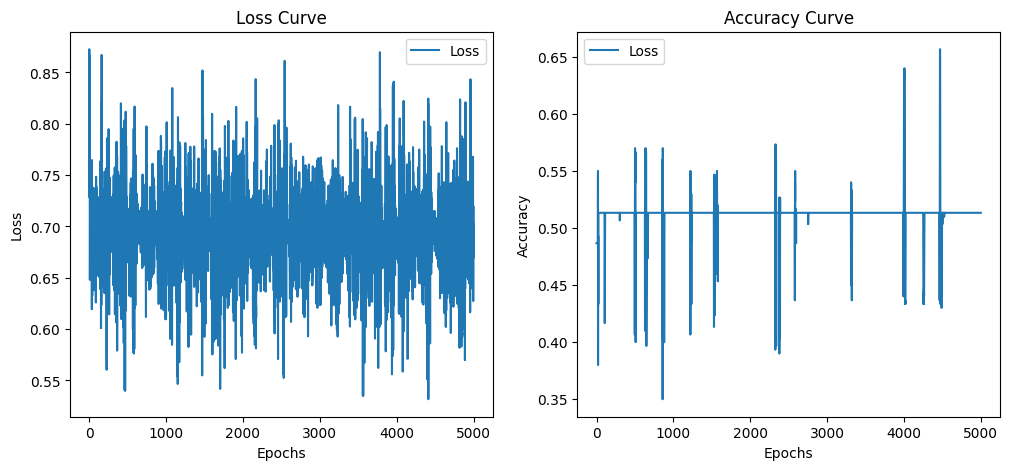

In [24]:
displayLearningCurves(loss_data, accuracy_data)

## Display Epochs to Convergence (FirstInstance)

In [10]:
def displayConvergeceFirstInstance(df, savename):    
    plt.figure(figsize=(12, 10))

    for depth in range(3):
        convergence_data = []
        for trial in range(int(df["Trial"].max())+1):
            trial_data = []
            for width in range(4):
                # Filter for the current trial, depth, and width
                filtered = df.query("Trial == @trial and Depth == @depth+1 and Width == @width+1 and Accuracy >= 0.9")
                # Get the first epoch where the condition is met
                first_epoch = filtered["Epoch"].iloc[0] if not filtered.empty else np.nan
                
                trial_data.append(first_epoch)

            convergence_data.append(trial_data)

        # Convert to NumPy array
        convergence_data = np.array(convergence_data)
        nan_data = np.isnan(convergence_data).sum(axis=0)
        # Compute mean while ignoring NaN values
        mean_epochs = np.nanmean(convergence_data, axis=0)
        std_epochs = np.nanstd(convergence_data, axis=0)

        plt.subplot(2, 3, depth+1)
        plt.bar(["1", "2", "3", "4"], mean_epochs, yerr=std_epochs, color='skyblue', edgecolor='black')

        # Labels and title
        plt.xlabel("Width")
        plt.ylabel("Convergence Epoch")
        plt.title(f"Epochs to Convergence for Depth = {depth+1}")

        plt.subplot(2, 3, depth+4)
        plt.bar(["1", "2", "3", "4"], nan_data, color='skyblue', edgecolor='black')

        # Labels and title
        plt.xlabel("Width")
        plt.ylabel("Number of NaN")
        plt.title(f"Failed Convergence")

    plt.savefig(f"Figures/{savename}_displayConvergeceFirstInstance.png", dpi=300, bbox_inches='tight')

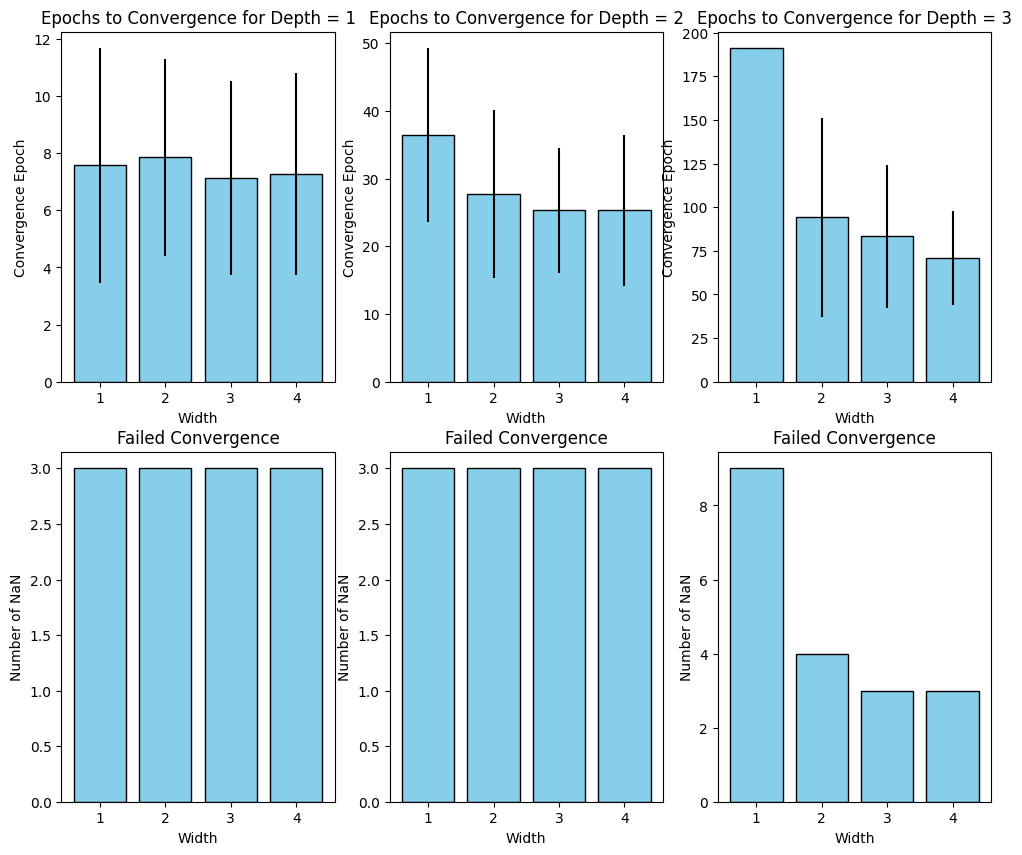

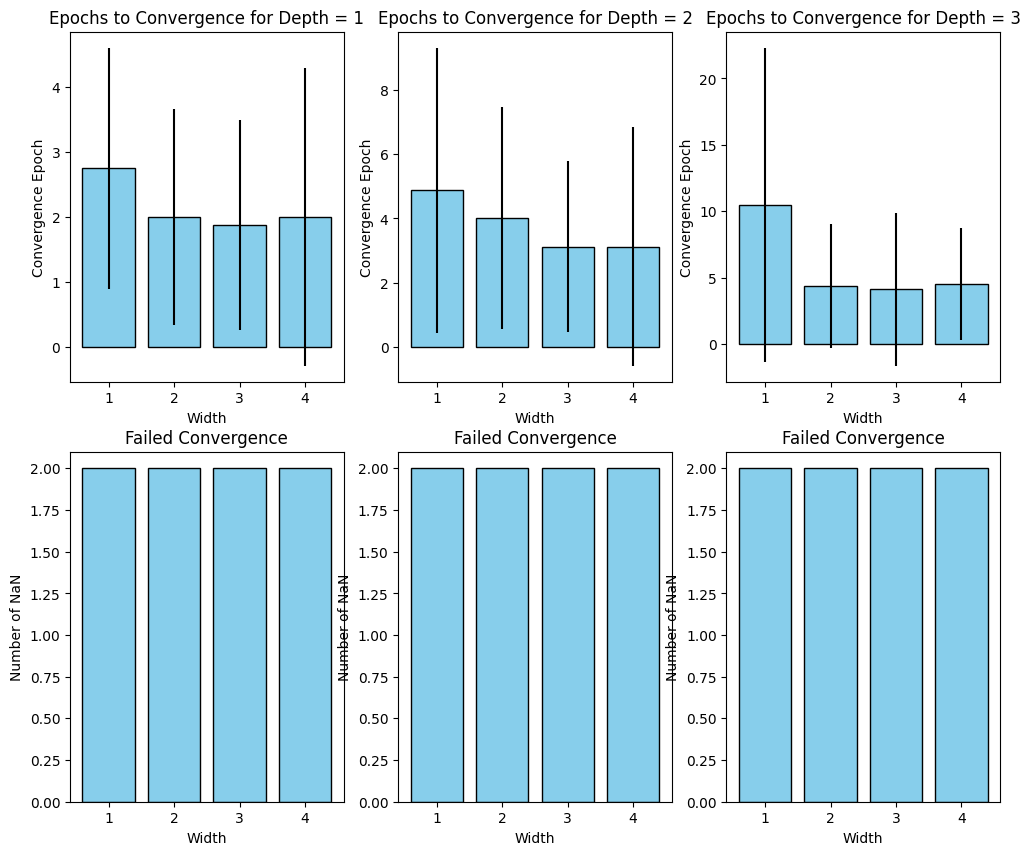

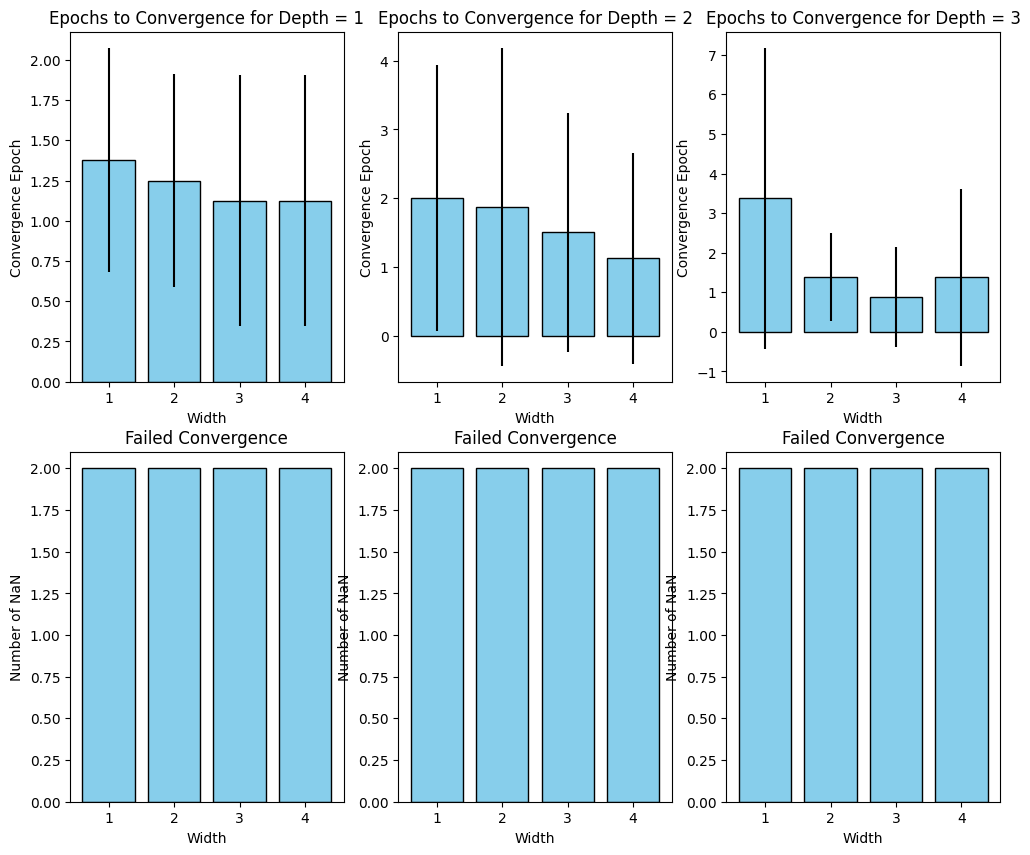

In [11]:
displayConvergeceFirstInstance(sigmoid_df, "sigmoid")
displayConvergeceFirstInstance(softsign_df, "softsign")
displayConvergeceFirstInstance(ReLU_df, "ReLU")

## Display Epochs to Convergence (MaxInstance)

In [12]:
def displayConvergeceMaxInstance(df, savename):    
    plt.figure(figsize=(12, 6))

    for depth in range(3):
        convergence_data = []
        for trial in range(int(df["Trial"].max())+1):
            trial_data = []
            for width in range(4):
                
                
                # Filter for the current trial, depth, and width
                filtered1 = df.query("Trial == @trial and Depth == @depth+1 and Width == @width+1")
                max_accuracy = filtered1["Accuracy"].max()
                filtered2 = df.query("Accuracy == @max_accuracy")
                # Get the first epoch where the condition is met
                first_epoch = filtered2["Epoch"].iloc[0] if not filtered2.empty else np.nan
                
                trial_data.append(first_epoch)

            convergence_data.append(trial_data)

        # Convert to NumPy array
        convergence_data = np.array(convergence_data)
        nan_data = np.isnan(convergence_data).sum(axis=0)
        # Compute mean while ignoring NaN values
        mean_epochs = np.nanmean(convergence_data, axis=0)
        std_epochs = np.nanstd(convergence_data, axis=0)

        plt.subplot(1, 3, depth+1)
        plt.bar(["1", "2", "3", "4"], mean_epochs, yerr=std_epochs, color='skyblue', edgecolor='black')

        # Labels and title
        plt.xlabel("Width")
        plt.ylabel("Convergence Epoch")
        plt.title(f"Epochs to Convergence for Depth = {depth+1}")

    plt.savefig(f"Figures/{savename}_displayConvergeceMaxInstance.png", dpi=300, bbox_inches='tight')

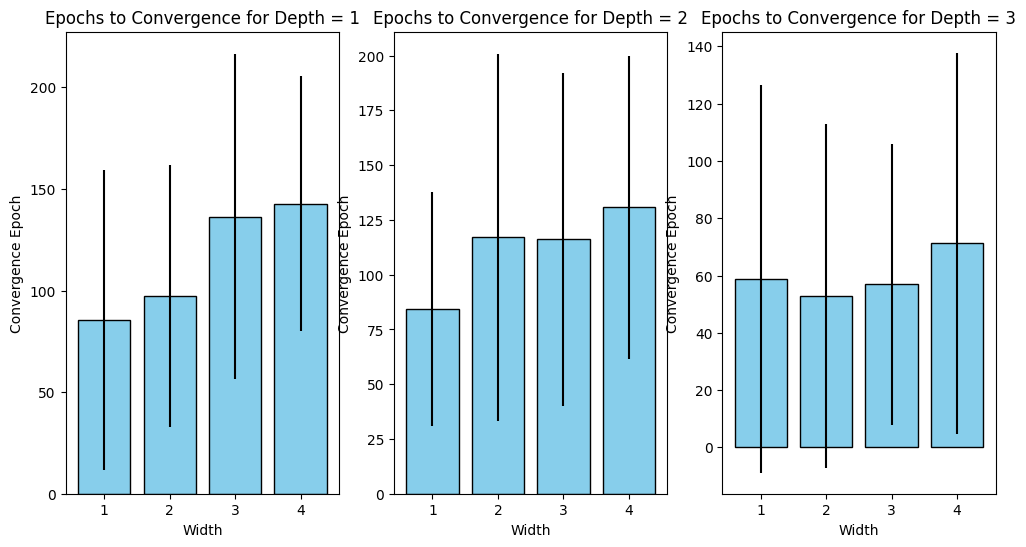

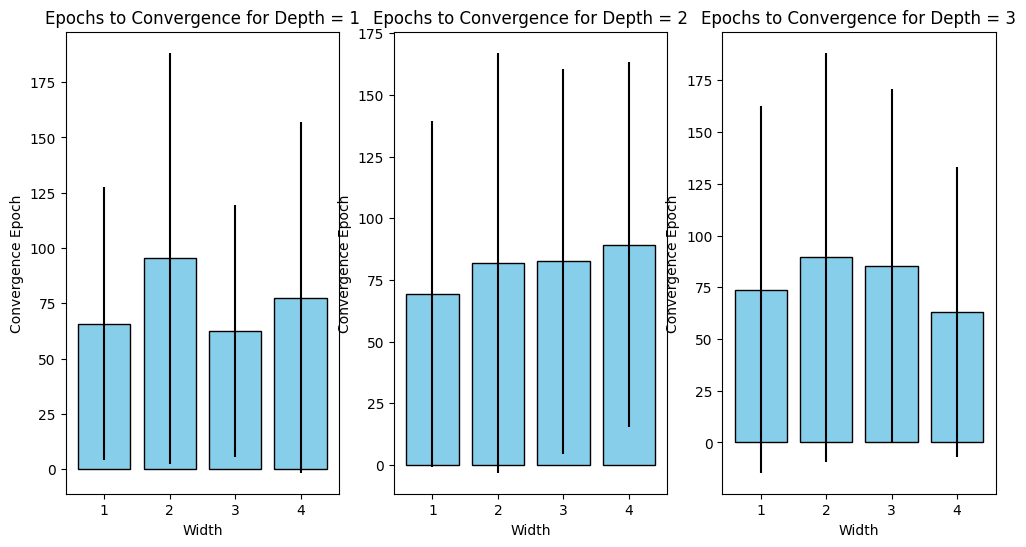

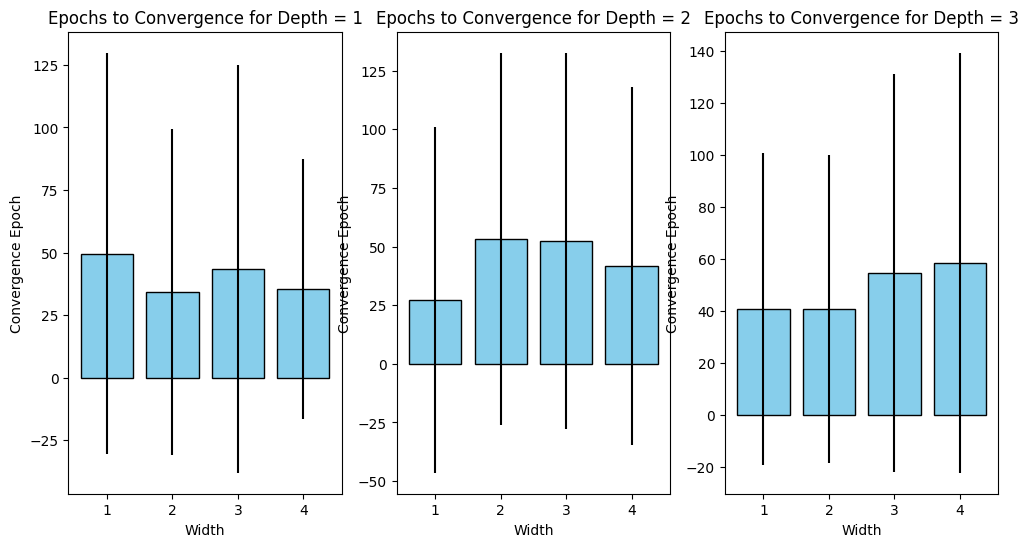

In [13]:
displayConvergeceMaxInstance(sigmoid_df, "sigmoid")
displayConvergeceMaxInstance(softsign_df, "softsign")
displayConvergeceMaxInstance(ReLU_df, "ReLU")

## Activation Saturation

In [14]:
# Plotting the mean values with error bars representing the standard deviation

def displayActivationSaturation(df, depth, savename):
    plt.figure(figsize=(12, 36))
    
    first_instance = []
    for width in range(4):
        # Filter for the current trial, depth, and width
        filtered = df.query("Trial == 3 and Depth == @depth and Width == @width+1")
        
        # Filter for the current trial, depth, and width
        filtered2 = filtered.query("Accuracy >= 0.8")

        # Get the first epoch where the condition is met
        first_epoch = filtered2["Epoch"].iloc[0] if not filtered.empty else np.nan
        first_instance.append(first_epoch)


        plt.subplot(5, 1, width+2)
        for layer in range(depth):
            plt.errorbar(range(250), filtered[f"Layer {layer+1} Mean Activations"], yerr=filtered[f"Layer {layer+1} STD Activations"], fmt='-o', capsize=5, capthick=1, label=f"Layer {layer+1}")
            
            # Draw a vertical line at the epoch with max accuracy
            max_accuracy = filtered["Accuracy"].max()
            filtered2 = df.query("Accuracy == @max_accuracy")      
            accuracy_epoch = filtered2["Epoch"].iloc[0] if not filtered2.empty else np.nan
            accuracy_value = filtered2["Accuracy"].iloc[0] if not filtered2.empty else np.nan
            plt.axvline(x=accuracy_epoch, color='red', linestyle='--', linewidth=2, label="Max Accuracy Epoch")
            # Annotate the max accuracy epoch
            plt.text(accuracy_epoch, max_accuracy, f"Epoch {accuracy_epoch}\nAcc: {accuracy_value:.2f}", 
                    color='red', fontsize=10, ha='center')


        # Labeling the plot
        plt.xlabel('Epoch')
        plt.ylabel('Mean Value')
        plt.title('Mean Values Across Epochs with Standard Deviation')
        plt.legend()
        plt.grid(True)


    plt.subplot(5, 1, 1)
    plt.bar(["1", "2", "3", "4"], first_instance, color='skyblue', edgecolor='black')
    
    plt.savefig(f"Figures/{savename}.png", dpi=300, bbox_inches='tight')

In [15]:
# Plotting the mean values with error bars representing the standard deviation

def displayActivationSaturation(df, depth, savename):
    plt.figure(figsize=(12, 36))
    
    first_instance = []
    max_instance = []
    accuracy_data = []
    for width in range(4):
        # Filter for the current trial, depth, and width
        filtered = df.query("Trial == 3 and Depth == @depth and Width == @width+1")
        
        # Filter for the current trial, depth, and width
        filtered2 = filtered.query("Accuracy >= 0.8")

        # Get the first epoch where the condition is met
        first_epoch = filtered2["Epoch"].iloc[0] if not filtered.empty else np.nan

        first_instance.append(first_epoch)

        # Get the first epoch where the condition is met
        max_accuracy = filtered["Accuracy"].max()
        filtered2 = df.query("Accuracy == @max_accuracy")
        max_epoch = filtered2["Epoch"].iloc[0] if not filtered2.empty else np.nan
        max_accuracy = filtered2["Accuracy"].iloc[0] if not filtered2.empty else np.nan
        max_instance.append(max_epoch)
        
        accuracy = filtered2["Accuracy"].iloc[0] if not filtered2.empty else np.nan
        accuracy_data.append(accuracy)

        plt.subplot(6, 1, width+3)
        for layer in range(depth):
            plt.errorbar(range(250), filtered[f"Layer {layer+1} Mean Activations"], yerr=filtered[f"Layer {layer+1} STD Activations"], fmt='-o', capsize=5, capthick=1, label=f"Layer {layer+1}")
            
        plt.axvline(x=first_epoch, color='blue', linestyle='--', linewidth=2, label="Max Accuracy Epoch")
        plt.axvline(x=max_epoch, color='red', linestyle='--', linewidth=2, label="Max Accuracy Epoch")

        # Annotate the max accuracy epoch
        plt.text(max_epoch, .6, f"Epoch {max_epoch}\nAcc: {max_accuracy:.2f}", 
                color='red', fontsize=10, ha='center')
                # Annotate the max accuracy epoch
        plt.text(first_epoch, .6, f"Epoch {max_epoch}\nAcc: {max_accuracy:.2f}", 
                color='blue', fontsize=10, ha='center')


    plt.savefig(f"Figures/{savename}.png", dpi=300, bbox_inches='tight')


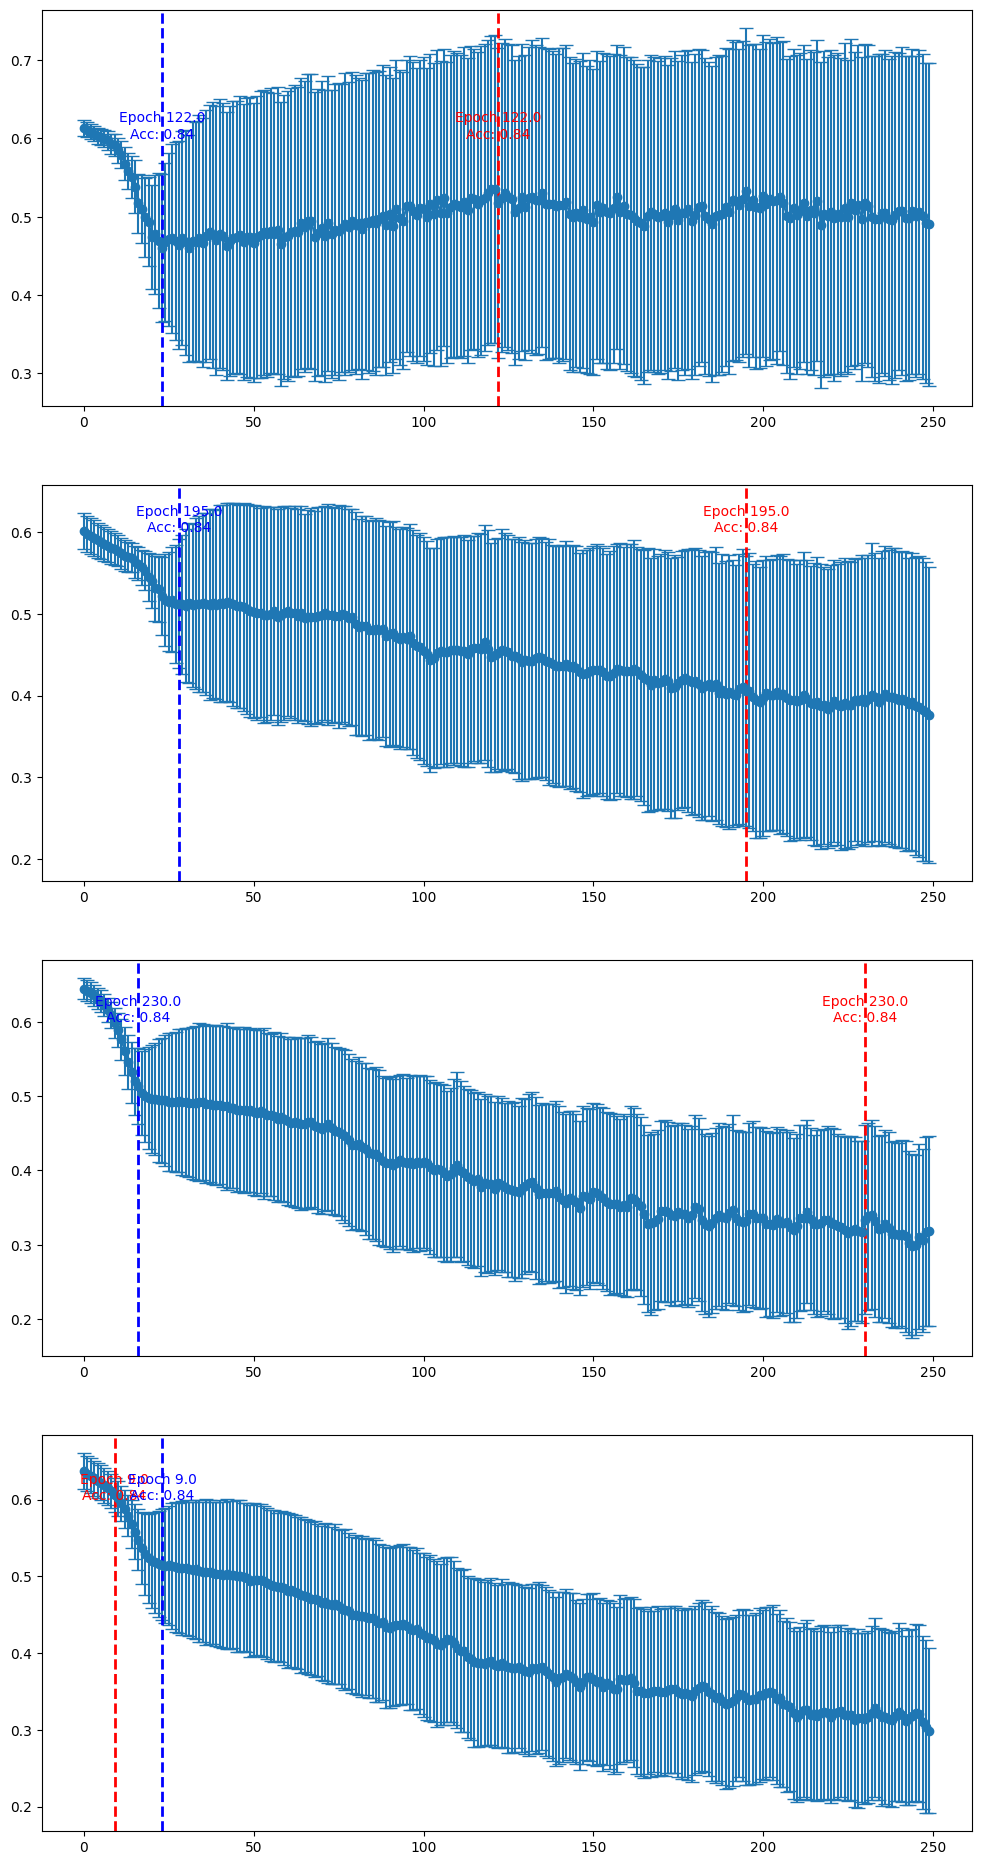

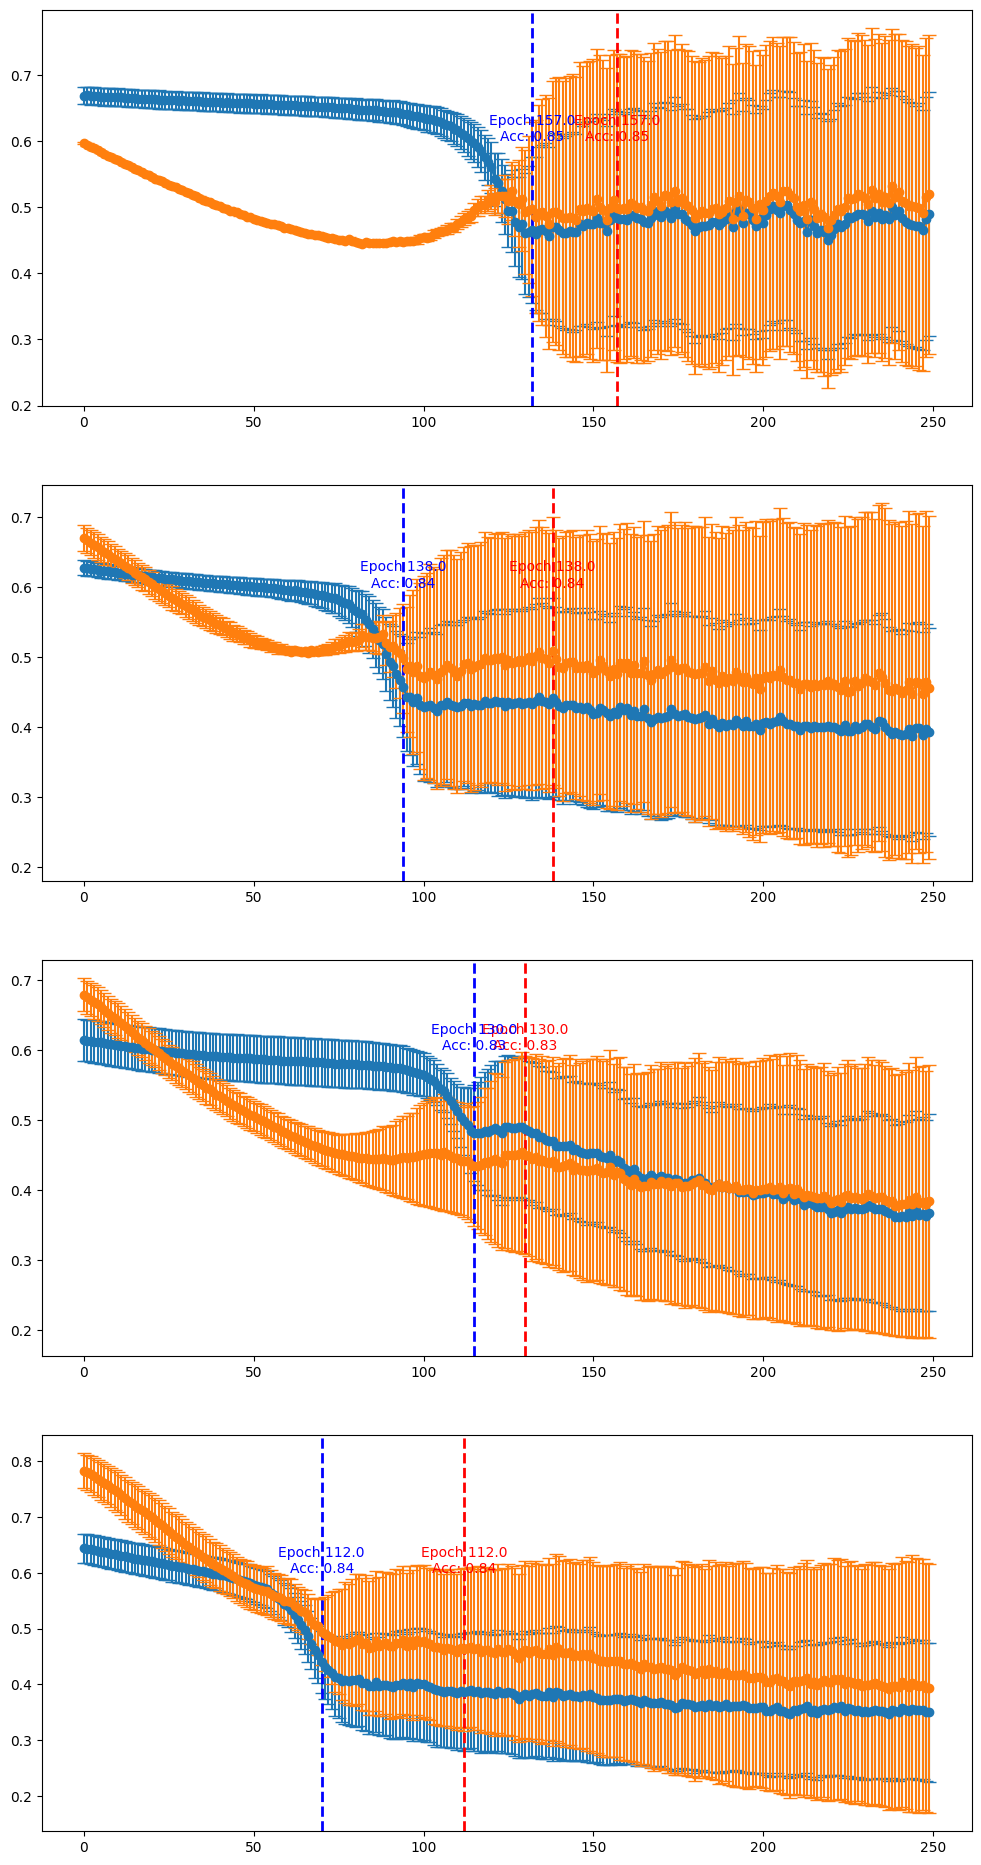

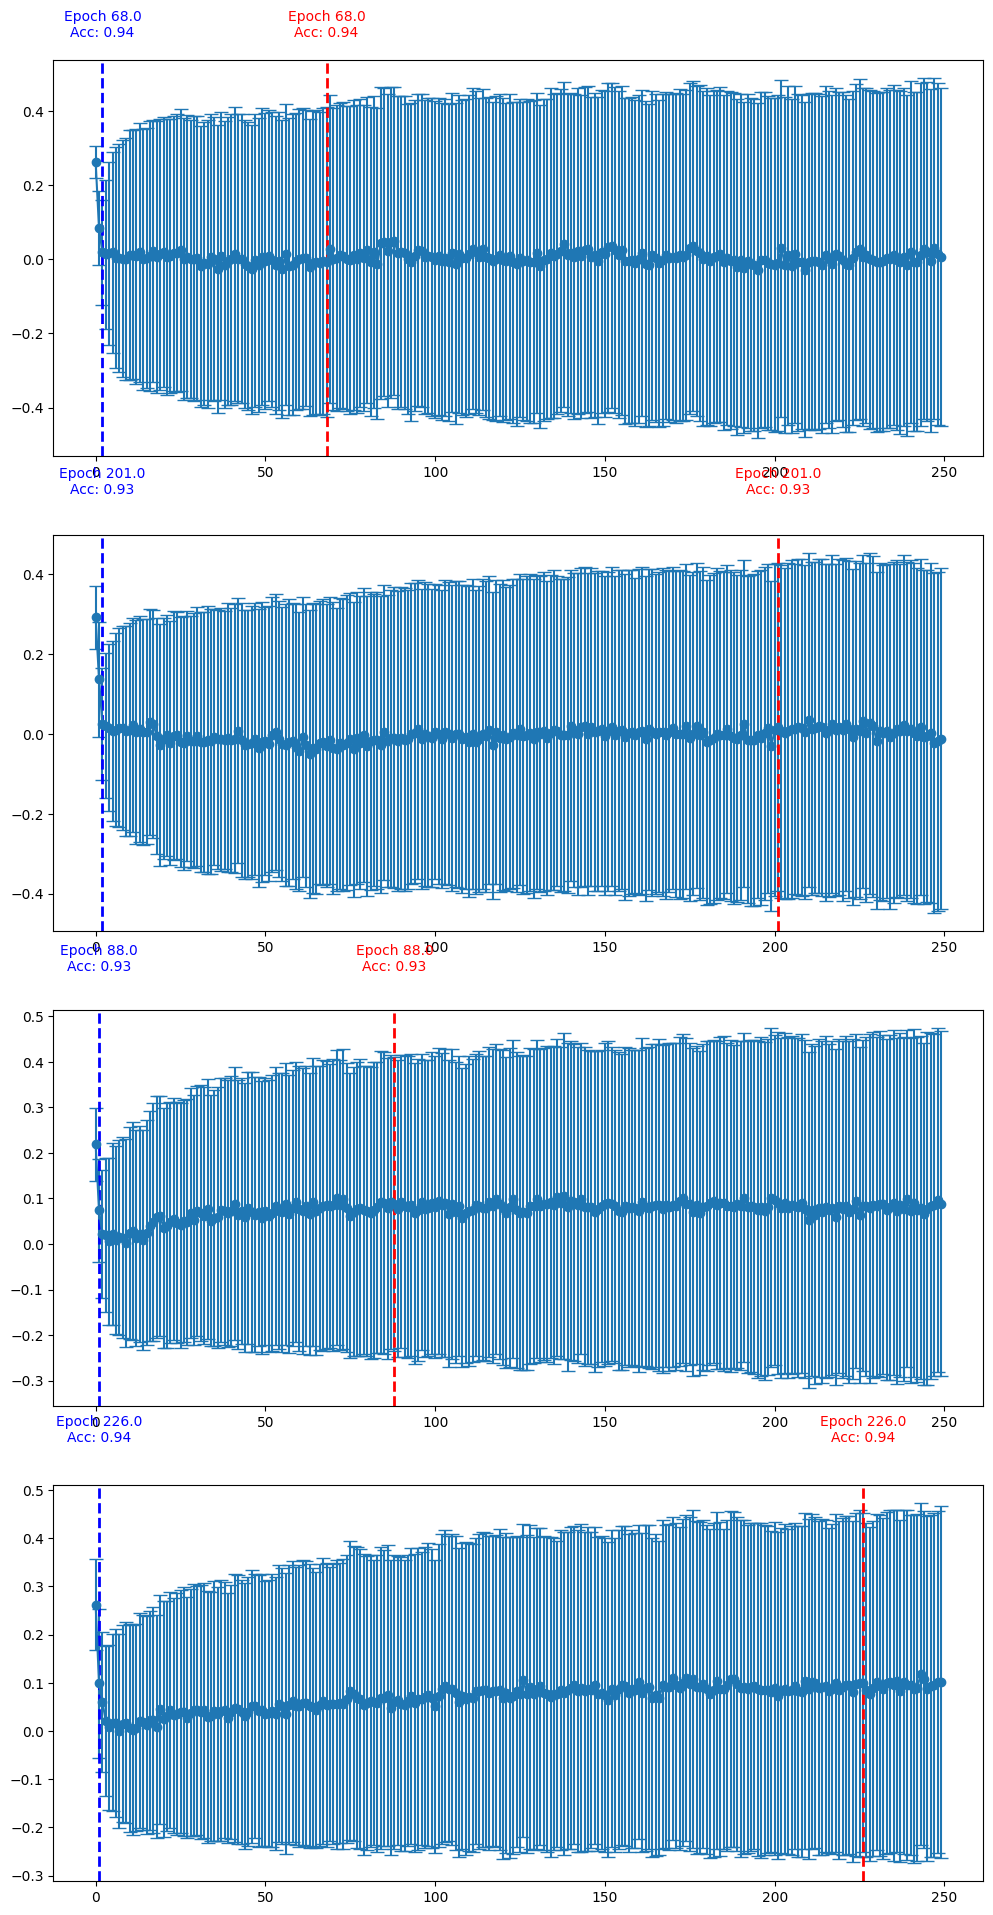

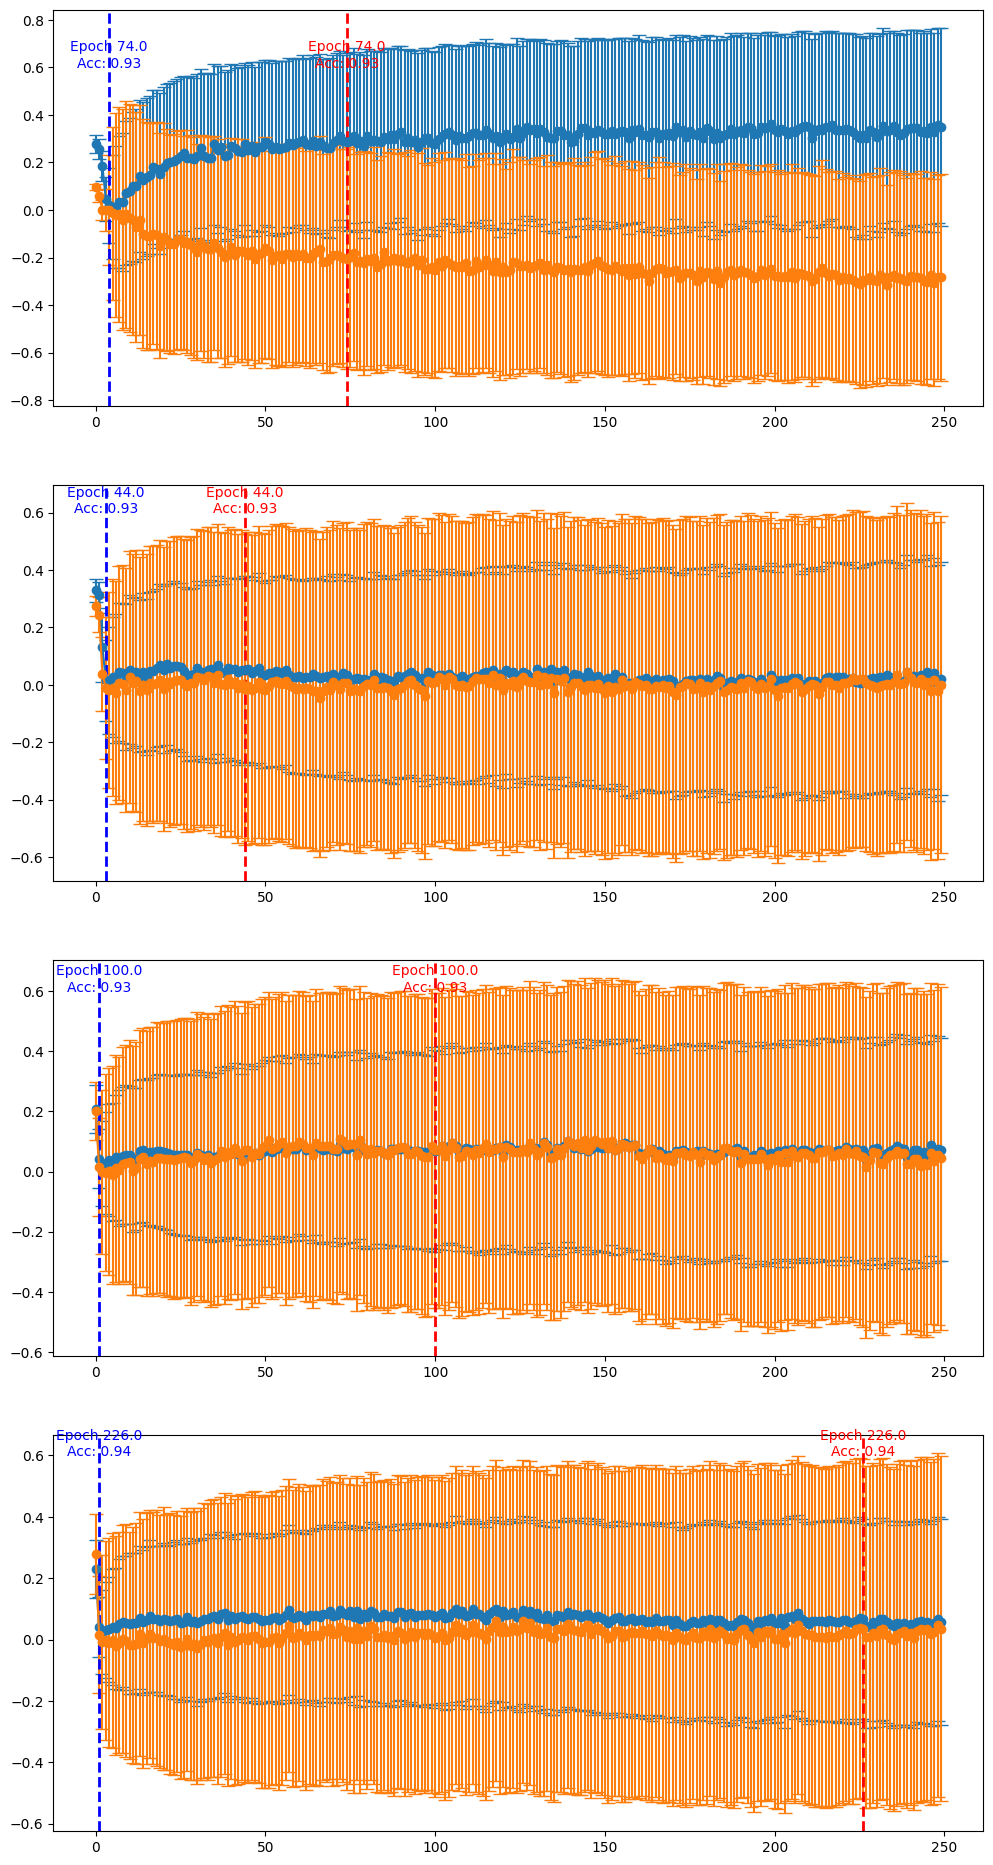

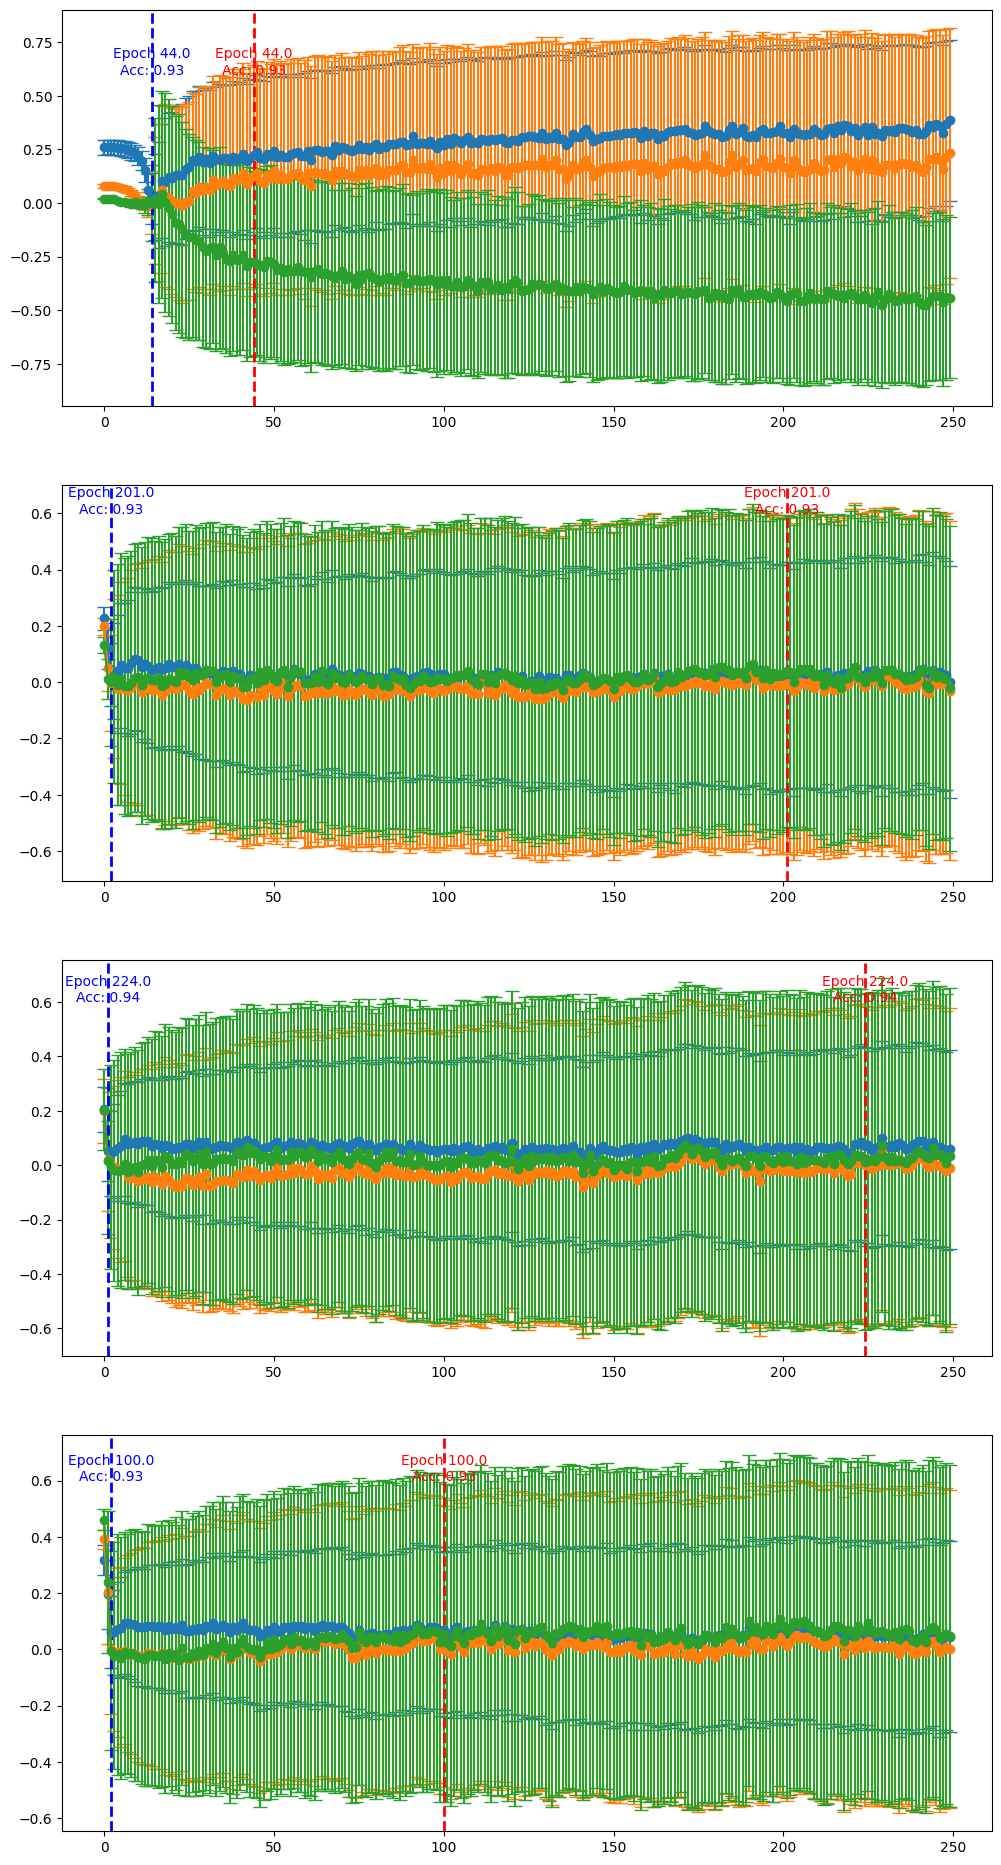

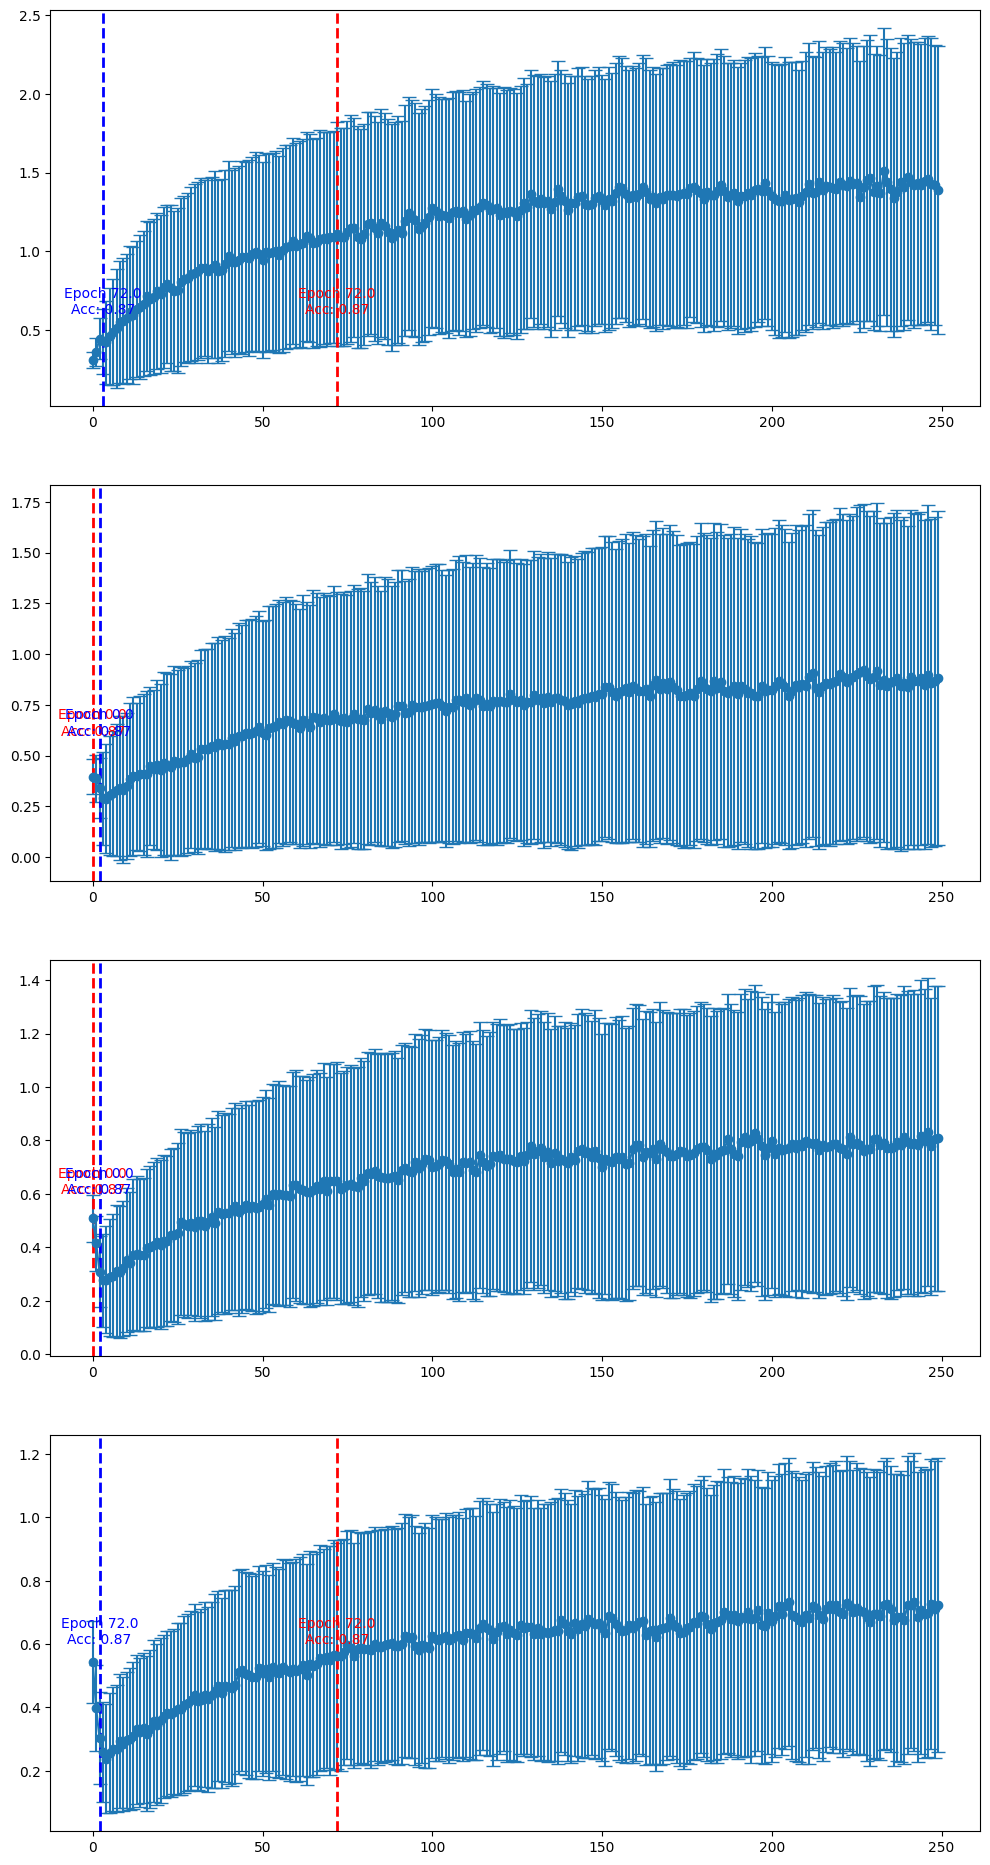

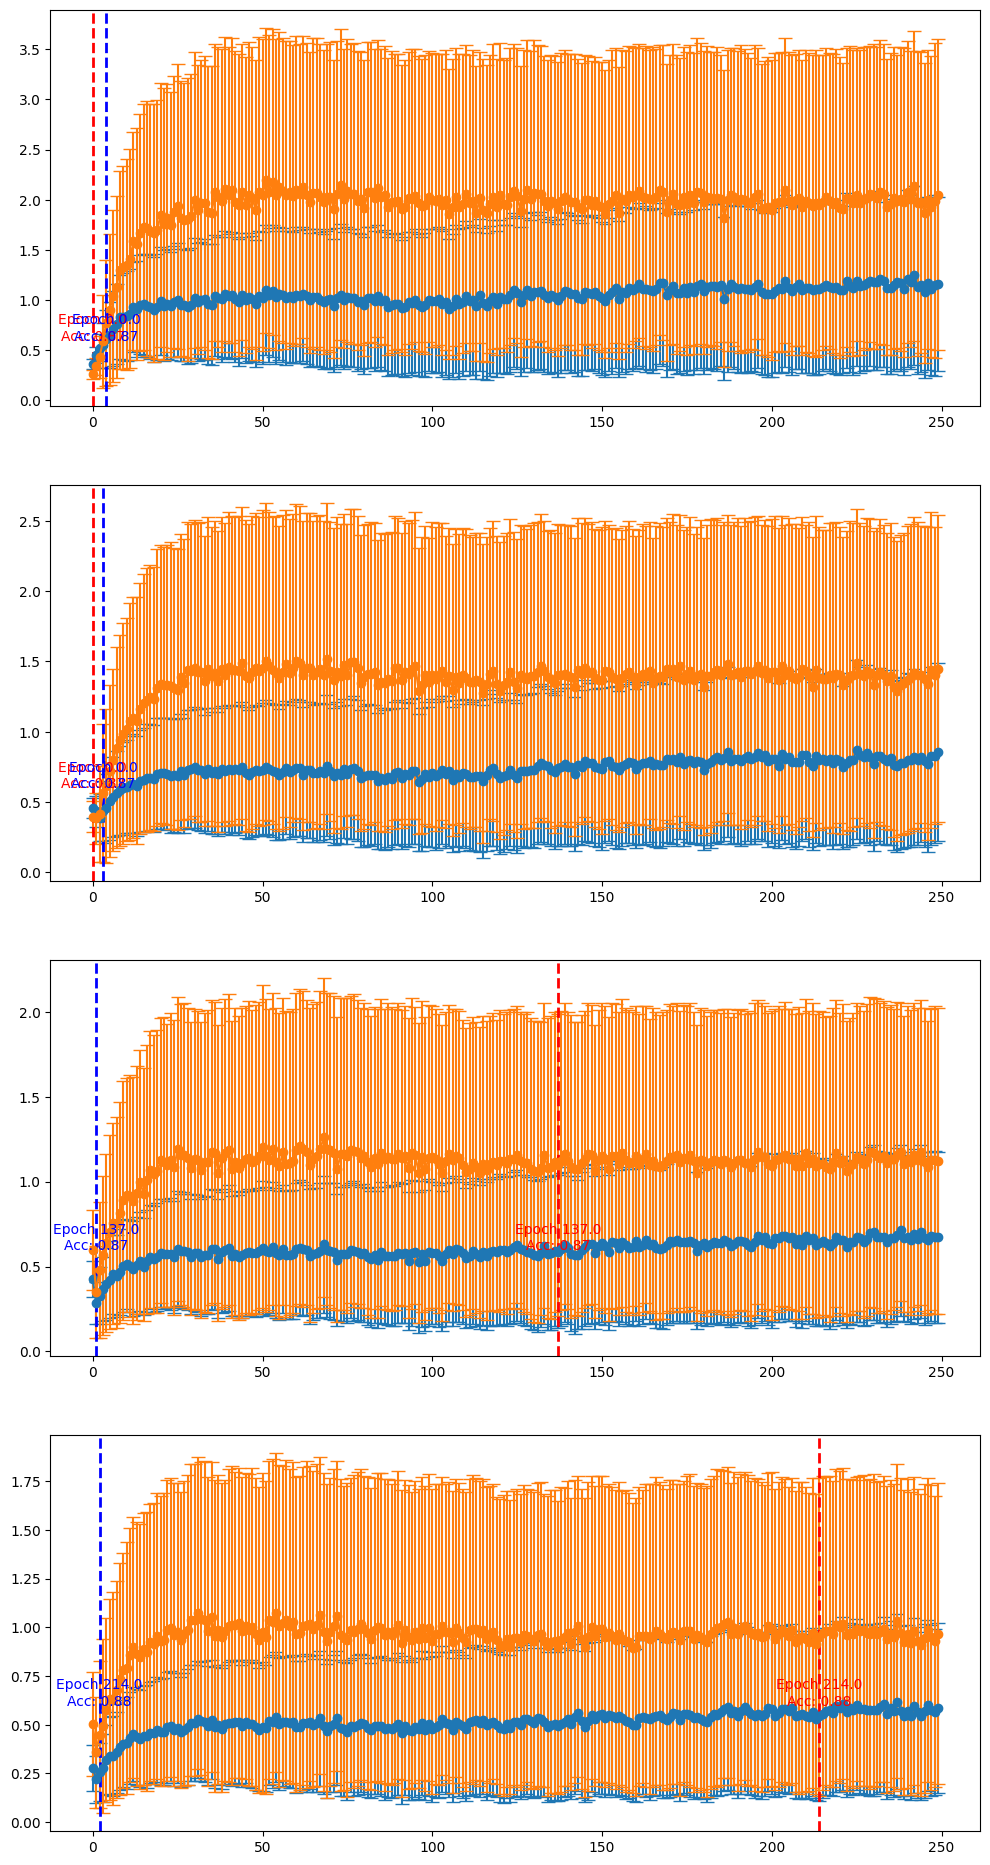

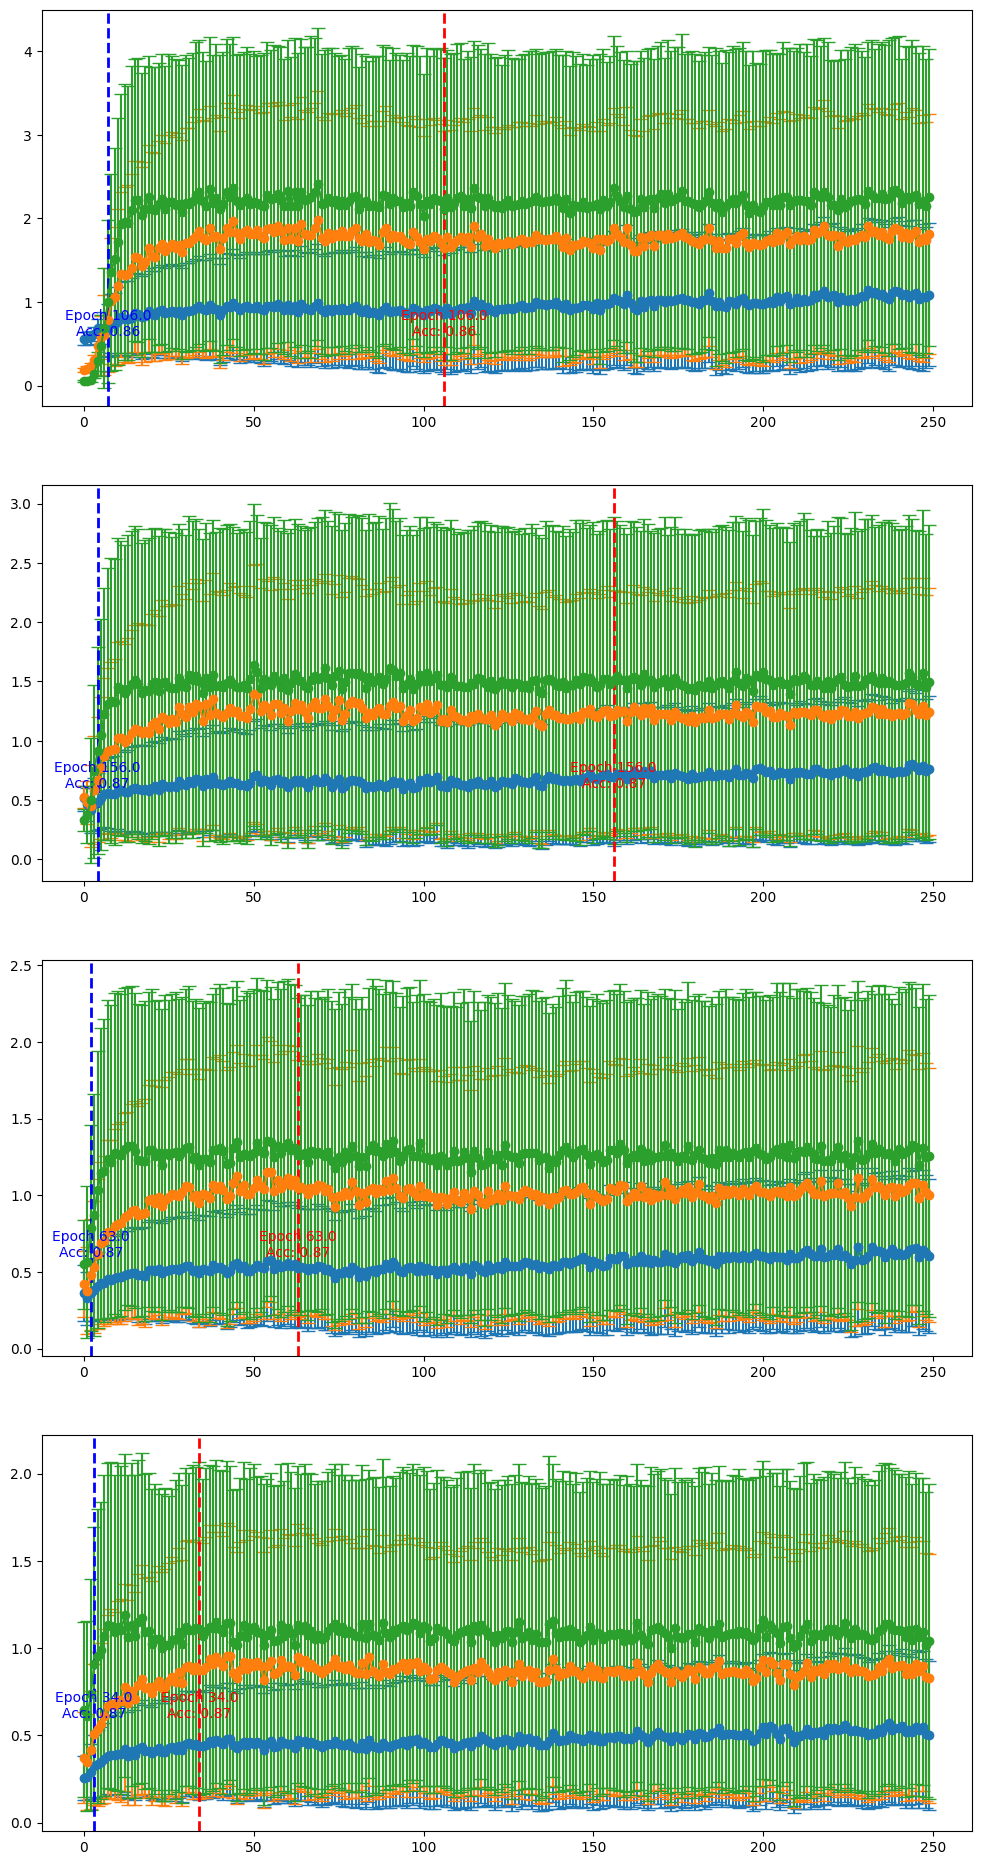

In [16]:
displayActivationSaturation(sigmoid_df, 1, "ActivationSaturation_Trial3_Depth1_Sigmoid")
displayActivationSaturation(sigmoid_df, 2, "ActivationSaturation_Trial3_Depth2_Sigmoid")
#displayActivationSaturation(sigmoid_df, 3, "ActivationSaturation_Trial3_Depth3_Sigmoid")

displayActivationSaturation(softsign_df, 1, "ActivationSaturation_Trial3_Depth1_Softsign")
displayActivationSaturation(softsign_df, 2, "ActivationSaturation_Trial3_Depth2_Softsign")
displayActivationSaturation(softsign_df, 3, "ActivationSaturation_Trial3_Depth3_Softsign")

displayActivationSaturation(ReLU_df, 1, "ActivationSaturation_Trial3_Depth1_ReLU")
displayActivationSaturation(ReLU_df, 2, "ActivationSaturation_Trial3_Depth2_ReLU")
displayActivationSaturation(ReLU_df, 3, "ActivationSaturation_Trial3_Depth3_ReLU")

## Gradient Data